In [1]:
! pip install catboost
! pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [2]:
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1Ux85UMh6Cs2Qy30Q7VgpV4gNAW_7vfkk" -O kaggle.json > /dev/null 2>&1

In [3]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction

  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 196MB/s]


In [5]:
!unzip "airline-passenger-satisfaction.zip"
!rm -rf "airline-passenger-satisfaction.zip"

Archive:  airline-passenger-satisfaction.zip
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

In [7]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [8]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [9]:
df_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [10]:
#drop duplicate rows
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [11]:
df_train.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [12]:
df_test.isnull().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [13]:
df_train['Arrival Delay in Minutes'].fillna(df_train['Arrival Delay in Minutes'].median(), inplace=True)

In [14]:
df_test['Arrival Delay in Minutes'].fillna(df_test['Arrival Delay in Minutes'].median(), inplace=True)

In [15]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [16]:
cat_features = df_train.select_dtypes('object').columns.to_list()
cat_features

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [17]:
unique_values_dict = {}
for col in cat_features:
  unique_values_dict[col] = df_train[col].unique()
unique_values_dict

{'Gender': array(['Male', 'Female'], dtype=object),
 'Customer Type': array(['Loyal Customer', 'disloyal Customer'], dtype=object),
 'Type of Travel': array(['Personal Travel', 'Business travel'], dtype=object),
 'Class': array(['Eco Plus', 'Business', 'Eco'], dtype=object),
 'satisfaction': array(['neutral or dissatisfied', 'satisfied'], dtype=object)}

In [18]:
df_train.replace({'Gender':{'Male':0,'Female':1}, 'Customer Type':{'Loyal Customer':0, 'disloyal Customer':1}, 'Type of Travel':{'Business travel': 0,'Personal Travel':1}, 'Class':{'Business': 0, 'Eco':1, 'Eco Plus': 2},'satisfaction':{'neutral or dissatisfied':0, "satisfied":1}}, inplace= True)
df_test.replace({'Gender':{'Male':0,'Female':1}, 'Customer Type':{'Loyal Customer':0, 'disloyal Customer':1}, 'Type of Travel':{'Business travel': 0,'Personal Travel':1}, 'Class':{'Business': 0, 'Eco':1, 'Eco Plus': 2},'satisfaction':{'neutral or dissatisfied':0, "satisfied":1}}, inplace= True)

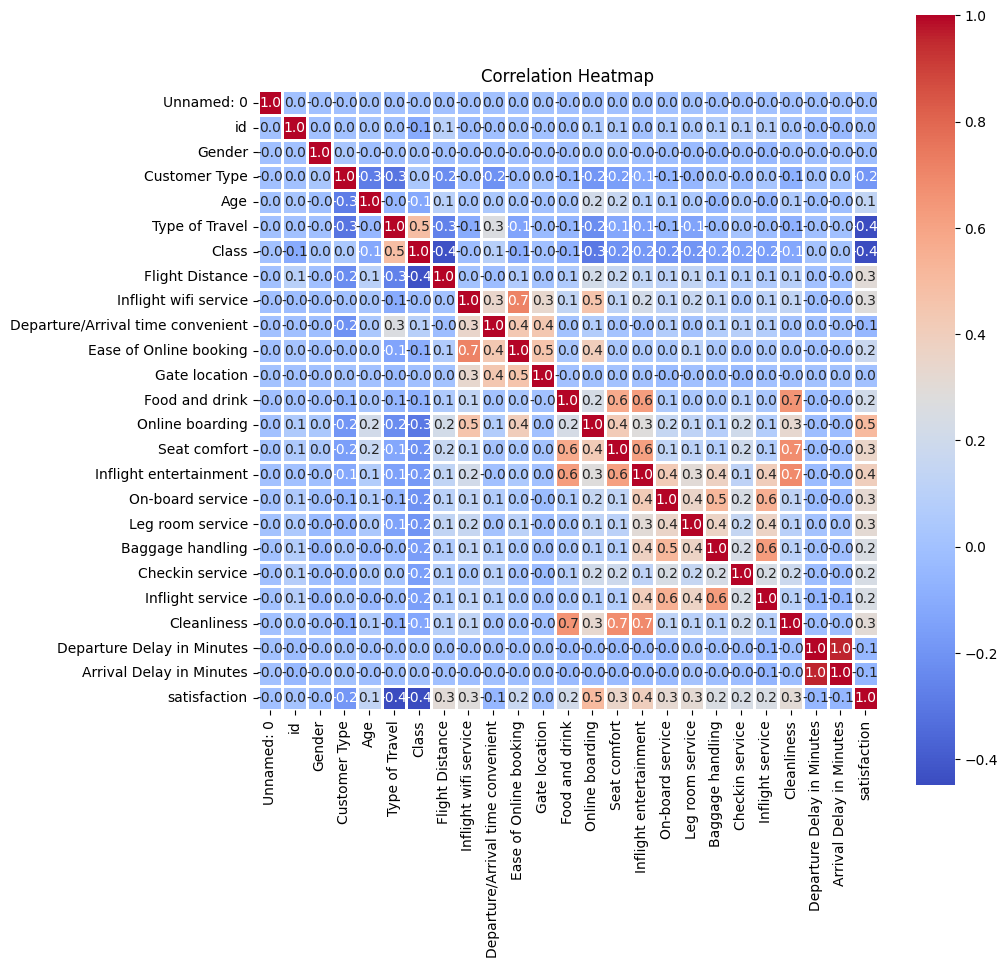

In [19]:
corr_mat = df_train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=1, fmt='.1f', square = True)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
df_train.drop(['Unnamed: 0', 'id','Gender'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'id','Gender'], axis=1, inplace=True)

In [21]:
X_train = df_train.drop('satisfaction',axis=1)
y_train = df_train['satisfaction']
X_test = df_test.drop('satisfaction',axis=1)
y_test = df_test['satisfaction']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(103904, 21) (103904,) (25976, 21) (25976,)


In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, loss_function='Logloss')

In [24]:
model.fit(X_train, y_train)

0:	learn: 0.5640107	total: 133ms	remaining: 26.5s
1:	learn: 0.4711497	total: 188ms	remaining: 18.6s
2:	learn: 0.3811501	total: 237ms	remaining: 15.5s
3:	learn: 0.3365206	total: 266ms	remaining: 13s
4:	learn: 0.3049429	total: 307ms	remaining: 12s
5:	learn: 0.2785511	total: 368ms	remaining: 11.9s
6:	learn: 0.2480616	total: 421ms	remaining: 11.6s
7:	learn: 0.2249658	total: 485ms	remaining: 11.6s
8:	learn: 0.2133150	total: 548ms	remaining: 11.6s
9:	learn: 0.2006406	total: 602ms	remaining: 11.4s
10:	learn: 0.1941658	total: 689ms	remaining: 11.8s
11:	learn: 0.1852300	total: 745ms	remaining: 11.7s
12:	learn: 0.1814627	total: 825ms	remaining: 11.9s
13:	learn: 0.1751589	total: 880ms	remaining: 11.7s
14:	learn: 0.1715645	total: 945ms	remaining: 11.7s
15:	learn: 0.1677595	total: 1.05s	remaining: 12s
16:	learn: 0.1642826	total: 1.14s	remaining: 12.3s
17:	learn: 0.1615284	total: 1.29s	remaining: 13s
18:	learn: 0.1577593	total: 1.39s	remaining: 13.2s
19:	learn: 0.1548310	total: 1.46s	remaining: 13.2

In [25]:
predictions = model.predict(X_test)

In [26]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[14270   303]
 [  635 10768]]


In [27]:
class_report_dict = classification_report(y_test, predictions,output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).transpose()
class_report_df

,precision,recall,f1-score,support
0,0.957397,0.979208,0.968180,14573.00000
1,0.972631,0.944313,0.958263,11403.00000
accuracy,0.963890,0.963890,0.963890,0.96389
macro avg,0.965014,0.961761,0.963221,25976.00000
weighted avg,0.964084,0.963890,0.963826,25976.00000


In [28]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9638897443794272